In [13]:
%pip install rdflib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import rdflib
import pandas as pd
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, XSD
import os

In [12]:
def create_rdf_graph(data_folder='data'):
    # Создаем RDF граф
    g = Graph()
    
    # Определяем пространства имен
    RECIPE = Namespace("http://example.org/recipe/")
    INGREDIENT = Namespace("http://example.org/ingredient/")
    STEP = Namespace("http://example.org/step/")
    TIME = Namespace("http://example.org/timecode/")
    SCHEMA = Namespace("http://schema.org/")
    
    # Загружаем данные из TSV файлов
    ingredients_df = pd.read_csv(os.path.join(data_folder, 'ingredients.tsv'), sep='\t')
    recipes_df = pd.read_csv(os.path.join(data_folder, 'recipes.tsv'), sep='\t')
    steps_df = pd.read_csv(os.path.join(data_folder, 'steps.tsv'), sep='\t')
    timecodes_df = pd.read_csv(os.path.join(data_folder, 'timecode.tsv'), sep='\t')
    
    # Добавляем ингредиенты
    for _, row in ingredients_df.iterrows():
        ingredient_uri = INGREDIENT[f"ingredient_{row['id']}"]
        g.add((ingredient_uri, RDF.type, SCHEMA.Ingredient))
        g.add((ingredient_uri, SCHEMA.name, Literal(row['name'])))
        g.add((ingredient_uri, SCHEMA.alternateName, Literal(row['lemma'])))
        g.add((ingredient_uri, SCHEMA.identifier, Literal(row['id'], datatype=XSD.integer)))
    
    # Добавляем рецепты
    for _, row in recipes_df.iterrows():
        recipe_uri = RECIPE[f"recipe_{row['id']}"]
        g.add((recipe_uri, RDF.type, SCHEMA.Recipe))
        g.add((recipe_uri, SCHEMA.name, Literal(row['title'])))
        g.add((recipe_uri, SCHEMA.url, Literal(row['url'])))
        g.add((ingredient_uri, SCHEMA.identifier, Literal(row['id'], datatype=XSD.integer)))
        
        # Добавляем ингредиенты рецепта
        if pd.notna(row['ingredient_ids']):
            ingredient_ids = [int(id_str) for id_str in row['ingredient_ids'].split('|')]
            for ing_id in ingredient_ids:
                ingredient_uri = INGREDIENT[f"ingredient_{ing_id}"]
                g.add((recipe_uri, SCHEMA.recipeIngredient, ingredient_uri))
        
        # Добавляем шаги рецепта
        if pd.notna(row['step_ids']):
            step_ids = [int(id_str) for id_str in row['step_ids'].split('|')]
            for step_id in step_ids:
                step_uri = STEP[f"step_{step_id}"]
                g.add((recipe_uri, SCHEMA.recipeInstructions, step_uri))
        
        # Добавляем дополнительные свойства
        g.add((recipe_uri, SCHEMA.totalTime, Literal(row['total_steps'], datatype=XSD.integer)))
        g.add((recipe_uri, SCHEMA.recipeYield, Literal(row['total_ingredients'], datatype=XSD.integer)))
        
        if pd.notna(row['mp4_url']):
            g.add((recipe_uri, SCHEMA.video, Literal(row['mp4_url'])))
        if pd.notna(row['youtube_url']):
            g.add((recipe_uri, SCHEMA.video, Literal(row['youtube_url'])))
        if pd.notna(row['local_video_path']):
            g.add((recipe_uri, SCHEMA.video, Literal(row['local_video_path'])))
    
    # Добавляем шаги приготовления
    for _, row in steps_df.iterrows():
        step_uri = STEP[f"step_{row['id']}"]
        g.add((step_uri, RDF.type, SCHEMA.HowToStep))
        g.add((step_uri, SCHEMA.name, Literal(row['step_number'])))
        g.add((step_uri, SCHEMA.text, Literal(row['description'])))
        g.add((step_uri, SCHEMA.position, Literal(row['step_index'], datatype=XSD.integer)))
        
        # Связываем шаг с рецептом
        recipe_uri = RECIPE[f"recipe_{row['recipe_id']}"]
        g.add((step_uri, SCHEMA.isPartOf, recipe_uri))
        
        # Добавляем ингредиенты, используемые в шаге
        if pd.notna(row['ingredients']):
            try:
                # Пытаемся преобразовать строку в список
                if isinstance(row['ingredients'], str) and row['ingredients'].startswith('[') and row['ingredients'].endswith(']'):
                    ingredient_ids = eval(row['ingredients'])
                else:
                    ingredient_ids = [int(id_str) for id_str in str(row['ingredients']).split(',')]
                
                for ing_id in ingredient_ids:
                    ingredient_uri = INGREDIENT[f"ingredient_{ing_id}"]
                    g.add((step_uri, SCHEMA.supply, ingredient_uri))
            except (ValueError, SyntaxError):
                # Если не удается распарсить, пропускаем
                pass
        
        # Добавляем изображение шага
        if pd.notna(row['image']):
            g.add((step_uri, SCHEMA.image, Literal(row['image'])))
    
    # Добавляем таймкоды
    for _, row in timecodes_df.iterrows():
        timecode_uri = TIME[f"timecode_{row['step_id']}"]
        step_uri = STEP[f"step_{row['step_id']}"]
        
        g.add((timecode_uri, RDF.type, SCHEMA.TimeCode))
        g.add((timecode_uri, SCHEMA.startTime, Literal(row['start_time'], datatype=XSD.integer)))
        g.add((timecode_uri, SCHEMA.endTime, Literal(row['end_time'], datatype=XSD.integer)))
        g.add((timecode_uri, SCHEMA.startTimeStr, Literal(row['start_time_str'])))
        g.add((timecode_uri, SCHEMA.endTimeStr, Literal(row['end_time_str'])))
        
        # Связываем таймкод с шагом
        g.add((step_uri, SCHEMA.hasTimeCode, timecode_uri))
        g.add((timecode_uri, SCHEMA.forStep, step_uri))
    
    return g

In [5]:
def save_rdf_graph(g, output_file='recipe_graph.ttl'):
    # Сохраняем граф в формате Turtle
    g.serialize(destination=output_file, format='turtle')
    print(f"RDF граф сохранен в файл: {output_file}")
    print(f"Всего триплетов: {len(g)}")

In [13]:
def rdf_run():
    # Создаем RDF граф
    graph = create_rdf_graph('./data/')
    
    # Сохраняем граф
    save_rdf_graph(graph, 'recipe_graph.ttl')
    
    # Выводим пример информации
    print("\nПример информации о рецептах:")
    for s, p, o in graph:
        if 'recipe' in str(s):
            print(f"{s} -> {p} -> {o}")
            break
    
    print("\nПример информации об ингредиентах:")
    for s, p, o in graph:
        if 'ingredient' in str(s):
            print(f"{s} -> {p} -> {o}")
            break
rdf_run()

RDF граф сохранен в файл: recipe_graph.ttl
Всего триплетов: 560

Пример информации о рецептах:
http://example.org/recipe/recipe_35 -> http://schema.org/video -> ./sources/35/vid__35.mp4

Пример информации об ингредиентах:
http://example.org/ingredient/ingredient_338 -> http://schema.org/identifier -> 338


Загружено 560 триплетов


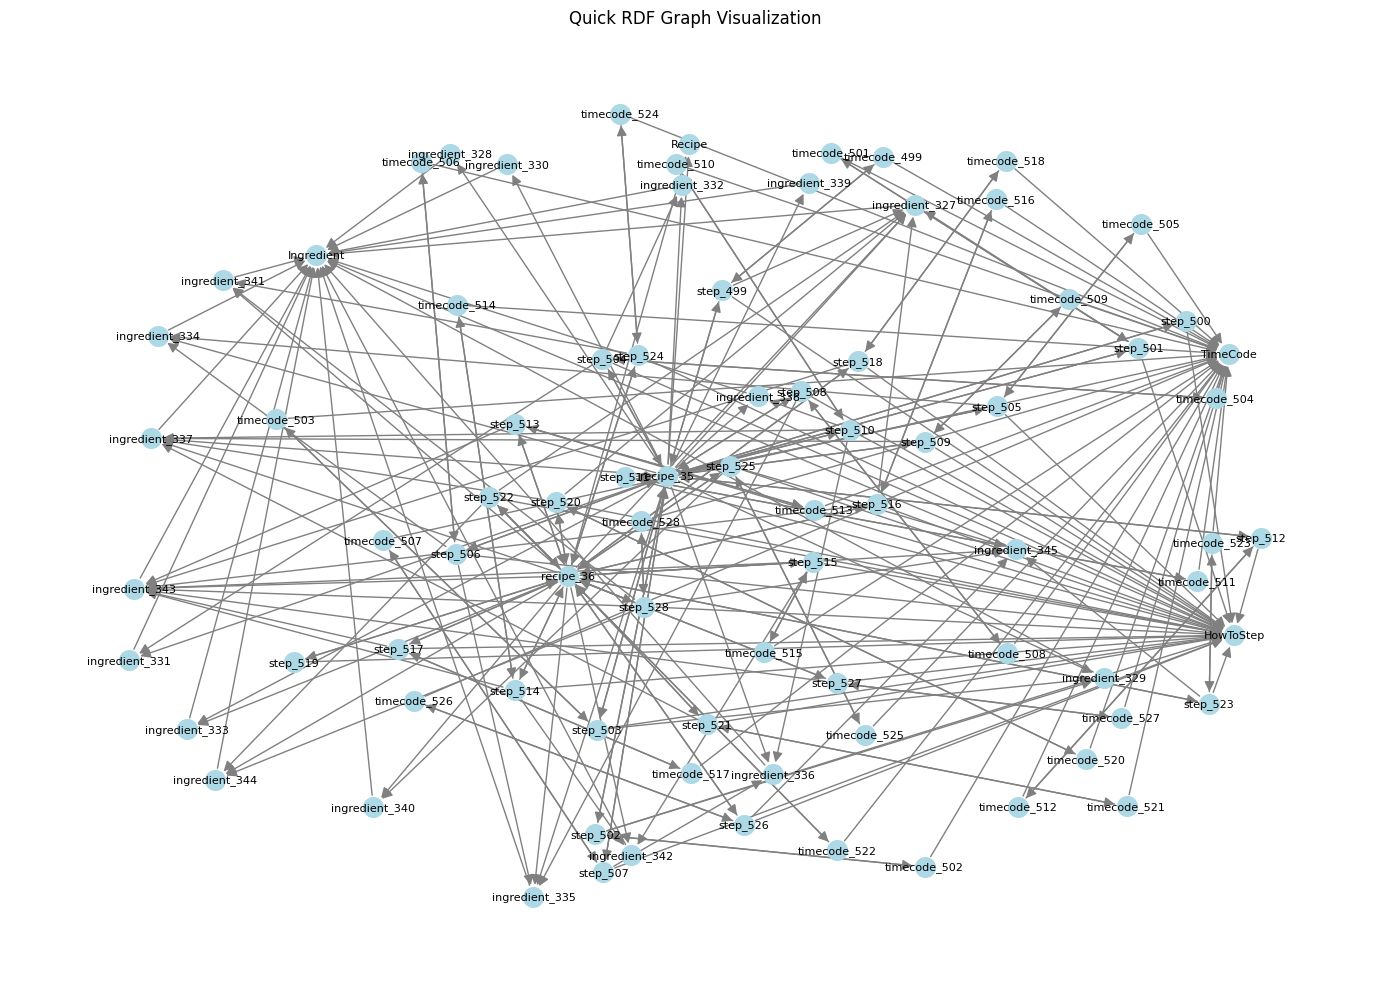

Сетевой граф создан: 83 узлов, 257 связей


In [4]:
def quick_rdf_visualization(ttl_file='recipe_graph.ttl'):
    """Быстрая визуализация RDF графа"""
    
    # Загрузка графа
    g = rdflib.Graph()
    g.parse(ttl_file, format='turtle')
    
    print(f"Загружено {len(g)} триплетов")
    
    # Создание сетевого графа
    G = nx.DiGraph()
    
    for s, p, o in g:
        if isinstance(s, rdflib.URIRef) and isinstance(o, rdflib.URIRef):
            subj = str(s).split('/')[-1]
            obj = str(o).split('/')[-1]
            pred = str(p).split('/')[-1]
            
            G.add_node(subj)
            G.add_node(obj)
            G.add_edge(subj, obj, label=pred)
    
    # Визуализация
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Quick RDF Graph Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('quick_rdf_visualization.png', dpi=300)
    plt.show()
    
    print(f"Сетевой граф создан: {G.number_of_nodes()} узлов, {G.number_of_edges()} связей")
quick_rdf_visualization('recipe_graph.ttl')

In [17]:
%pip install nbformat==4.2.0

  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata (755 bytes)
   ---------------------------------------- 0.0/153.3 kB ? eta -:--:--
   ------- ------------------------------- 30.7/153.3 kB 435.7 kB/s eta 0:00:01
   ------------------ -------------------- 71.7/153.3 kB 787.7 kB/s eta 0:00:01
   ---------------------------------------- 153.3/153.3 kB 1.1 MB/s eta 0:00:00
Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.10.4
    Uninstalling nbformat-5.10.4:
      Successfully uninstalled nbformat-5.10.4
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
